In [20]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from eval_utils import filter_tasks
from chunked_pooling.chunked_eval_tasks import *

OUTPUT_DIR = "results"

In [21]:
tasks = set(filter_tasks(get_eval_tasks()))
def preprocess_result():
    # Step 1: 读取 JSON 数据
    with open(f"{OUTPUT_DIR}/benchmark.json", "r") as f:
        data = json.load(f)

    # Step 2: 数据整理
    # 将所有的测试结果提取到一个列表中
    records = []
    for item in data:
        if item is None:
            continue
        assert len(item["scores"]) == 1, "More than one eval splits scores founded."
        # 大于1024的chunk size测试不全，先不看
        if item["chunk_size"] > 1024 or item["task_name"] not in tasks:
            continue
        if "llama" in item["chunking_strategy"]:
            continue
        if item["chunk_size"] == 1024 and "bce" in item['model_name']:
            continue
        if item["task_name"] != "LEMBWikimQARetrievalChunked":
            continue
        scores = list(item["scores"].values())[0][0]
        records.append(
            {
                "dataset_revision": item.get("dataset_revision", None),
                "task_name": item.get("task_name", None),
                "mteb_version": item.get("mteb_version", None),
                "evaluation_time": item.get("evaluation_time", None),
                "kg_co2_emissions": item.get("kg_co2_emissions", None),
                "model_name": item.get("model_name", None),
                "chunking_strategy": item.get("chunking_strategy", None),
                "chunk_size": item.get("chunk_size", None),
                "n_sentences": item.get("n_sentences", None),
                "chunking_model": item.get("chunking_model", None),
                "hf_subset": scores.get("hf_subset", None),
                "main_score": scores.get("main_score", None),
                "ndcg_at_1": scores.get("ndcg_at_1", None),
                "ndcg_at_3": scores.get("ndcg_at_3", None),
                "ndcg_at_5": scores.get("ndcg_at_5", None),
                "ndcg_at_10": scores.get("ndcg_at_10", None),
                "ndcg_at_20": scores.get("ndcg_at_20", None),
                "map_at_1": scores.get("map_at_1", None),
                "map_at_3": scores.get("map_at_3", None),
                "map_at_5": scores.get("map_at_5", None),
                "map_at_10": scores.get("map_at_10", None),
                "map_at_20": scores.get("map_at_20", None),
                "recall_at_1": scores.get("recall_at_1", None),
                "recall_at_3": scores.get("recall_at_3", None),
                "recall_at_5": scores.get("recall_at_5", None),
                "recall_at_10": scores.get("recall_at_10", None),
                "recall_at_20": scores.get("recall_at_20", None),
                "precision_at_1": scores.get("precision_at_1", None),
                "precision_at_3": scores.get("precision_at_3", None),
                "precision_at_5": scores.get("precision_at_5", None),
                "precision_at_10": scores.get("precision_at_10", None),
                "precision_at_20": scores.get("precision_at_20", None),
                "mrr_at_1": scores.get("mrr_at_1", None),
                "mrr_at_3": scores.get("mrr_at_3", None),
                "mrr_at_5": scores.get("mrr_at_5", None),
                "mrr_at_10": scores.get("mrr_at_10", None),
                "mrr_at_20": scores.get("mrr_at_20", None),
                "languages": scores["languages"][0] if scores["languages"] else None,
            }
        )

    # 转换为 Pandas DataFrame
    df = pd.DataFrame(records)

    return df

In [22]:
df = preprocess_result()

In [23]:
# 定义一个自定义函数来分类 languages 列的值
def categorize_language(language):
    if language == 'eng-Latn':
        return 'Eng'
    elif language == 'zh':
        return 'Zh'
    elif language in ['en-zh', 'zh-en']:
        return 'Cross Eng-Zh'
    else:
        return '未知'

# 创建新的列 language_category
df['language_category'] = df['languages'].apply(categorize_language)

In [24]:
dataset_volume = {}
with open("sample_count.json", "r") as f:
    sample_count = json.load(f)
    for task_name, count in sample_count.items():
        if task_name not in tasks:
            continue
        dataset_volume[task_name] = count["queries"] + count["corpus"]

# 添加数据量信息
task_volume_df = pd.DataFrame(list(dataset_volume.items()), columns=['task_name', 'data_volume'])
# 将 task_volume_df 信息合并到原 DataFrame 中
df = df.merge(task_volume_df, on='task_name', how='left')

# 添加一列新的，用于表示数据量乘以得分
df['weighted_score'] = df['main_score'] * df['data_volume']


# 自定义加权平均数函数
def weighted_avg(group):
    total_weighted_score = group['weighted_score'].sum()
    total_data_volume = group['data_volume'].sum()
    weighted_avg_score = round((total_weighted_score / total_data_volume), 3)
    return pd.Series({'weighted_avg_score': weighted_avg_score})


# 计算总的加权平均分（不按语言分类）
avg_scores = df.groupby(['chunking_strategy', 'chunk_size', 'model_name']).apply(weighted_avg).reset_index()

# 计算按 language_category 分类的加权平均分
avg_scores_by_language = df.groupby(['chunking_strategy', 'chunk_size', 'model_name', 'language_category']).apply(weighted_avg).reset_index()

/tmp/ipykernel_3998110/2100878808.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_scores = df.groupby(['chunking_strategy', 'chunk_size', 'model_name']).apply(weighted_avg).reset_index()
/tmp/ipykernel_3998110/2100878808.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_scores_by_language = df.groupby(['chunking_strategy', 'chunk_size', 'model_name', 'language_category']).apply(weighted_avg)

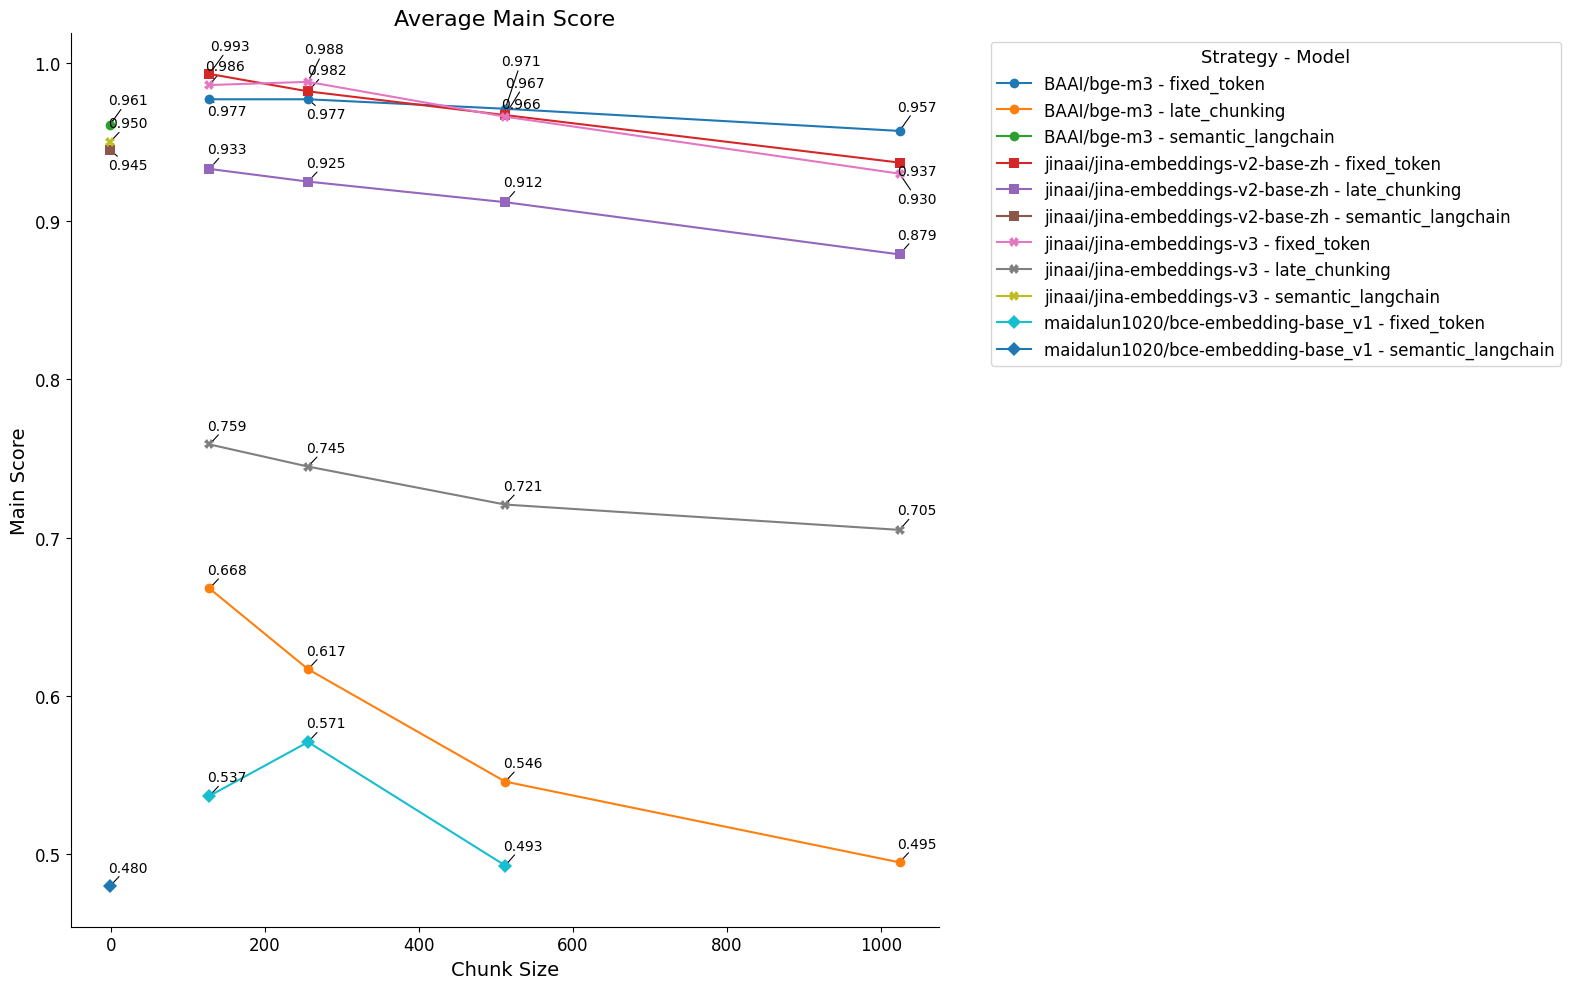

In [25]:
# 创建一个新的列，将 chunking_strategy 和 model_name 组合在一起
avg_scores['strategy_model'] = avg_scores['model_name'] + " - " + avg_scores['chunking_strategy']

strategy_model = sorted(avg_scores['strategy_model'].unique().tolist())
model_names = sorted(avg_scores['model_name'].unique().tolist())
strategy_names = sorted(avg_scores['chunking_strategy'].unique().tolist())

# 设置调色板
palette = sns.color_palette(n_colors=len(strategy_model))

# 定义不同模型的marker
markers = ["o", "s", "X", "D", "^", "v", "<", ">"]  # 圆圈，方块，叉号，菱形，三角形朝上，三角形朝下，三角形朝左，三角形朝右

# 创建一个字典来映射模型到marker
marker_dict = {model: markers[i % len(markers)] for i, model in enumerate(model_names)}

# 创建一个字典来映射策略模型组合到颜色
color_dict = {strategy_model: palette[i] for i, strategy_model in enumerate(strategy_model)}

# 绘制折线图
text_plot = []
points_x = []
points_y = []
x_raidus = 0.1
y_radius = 0.001
plt.figure(figsize=(16, 10))
for strategy_model in strategy_model:
    subset = avg_scores[avg_scores['strategy_model'] == strategy_model]
    model = strategy_model.split(" - ")[0]
    mar = marker_dict[model]
    color = color_dict[strategy_model]
    plt.plot(subset['chunk_size'], subset['weighted_avg_score'], marker=mar, color=color, label=strategy_model, markeredgewidth=0, markersize=7)

    for px,py in zip(list(subset['chunk_size']), list(subset['weighted_avg_score'])):
        for dx in [x_raidus, 0, -x_raidus]:
            for dy in [y_radius, 0, -y_radius]:
                points_x.append(px + dx)
                points_y.append(py + dy)

    # 添加每个点的具体数值
    for i in range(len(subset)):
        x = subset['chunk_size'].iloc[i]
        y = subset['weighted_avg_score'].iloc[i]
        text_plot.append(plt.text(x, y, f'{y:.3f}', fontsize=10))
adjust_text(text_plot, x=points_x, y=points_y,arrowprops=dict(arrowstyle='->', color='black', lw=0.8), ax=plt.gca(), max_move=50)

# 添加图例和标签
plt.legend(title='Strategy - Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='13')
plt.xlabel("Chunk Size", fontsize=14)
plt.ylabel("Main Score", fontsize=14)
plt.title('Average Main Score', fontsize=16)

# 设置刻度字体大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# 美观起见隐藏顶部与右侧边框线
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# 显示图形
plt.tight_layout()
plt.show()

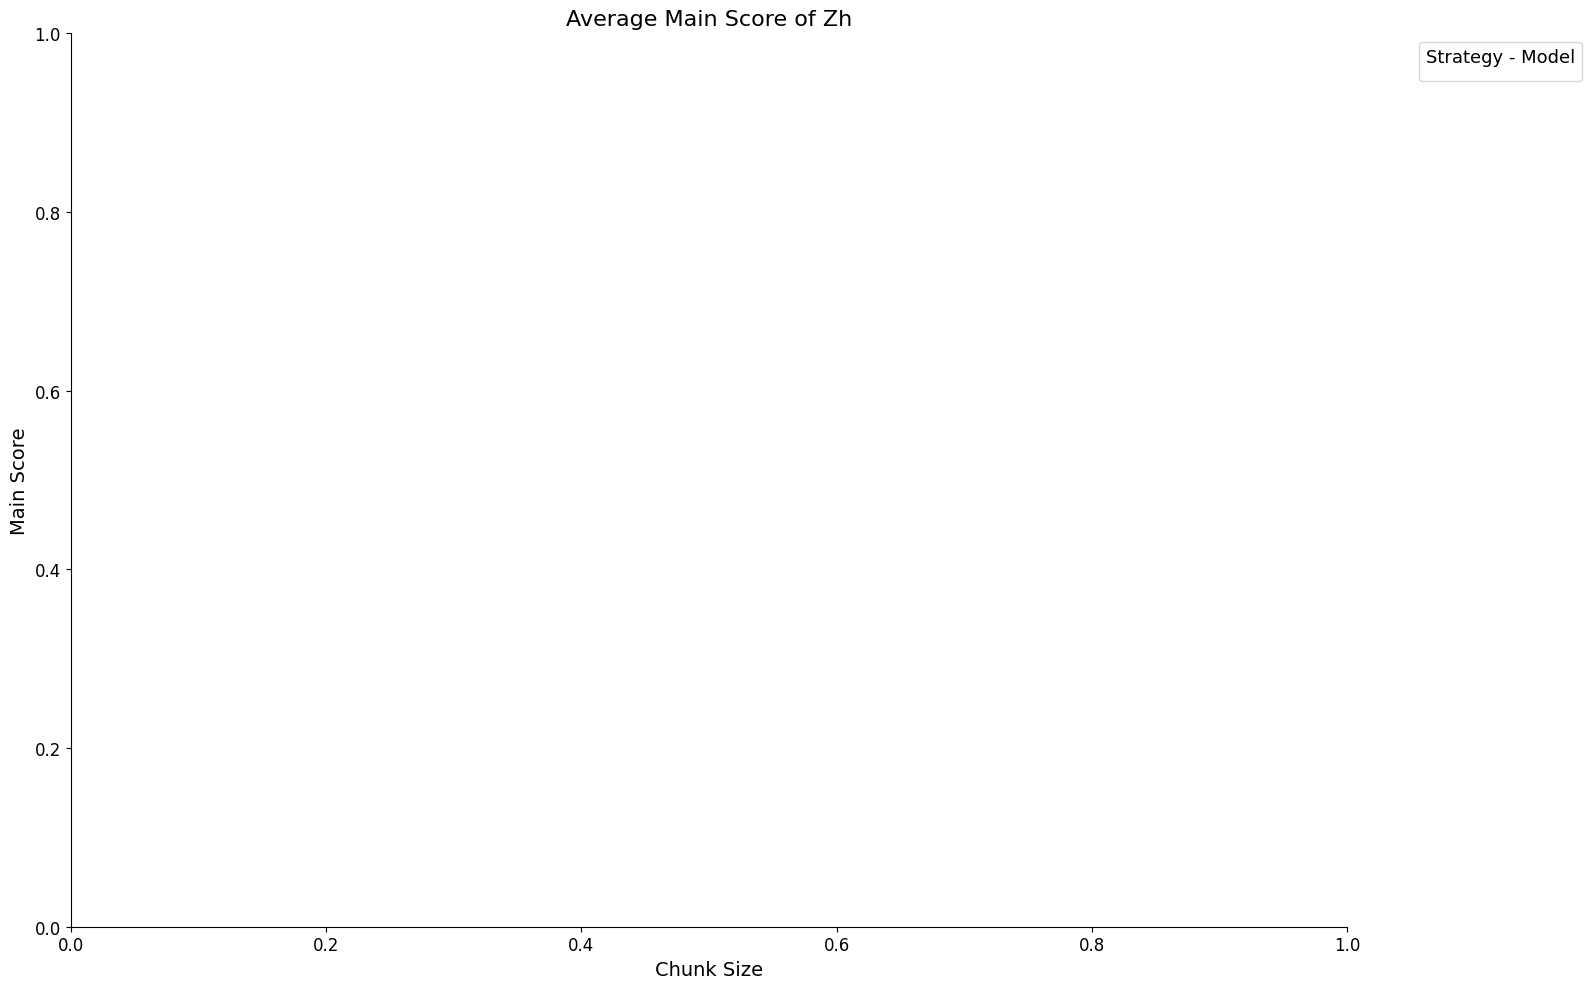

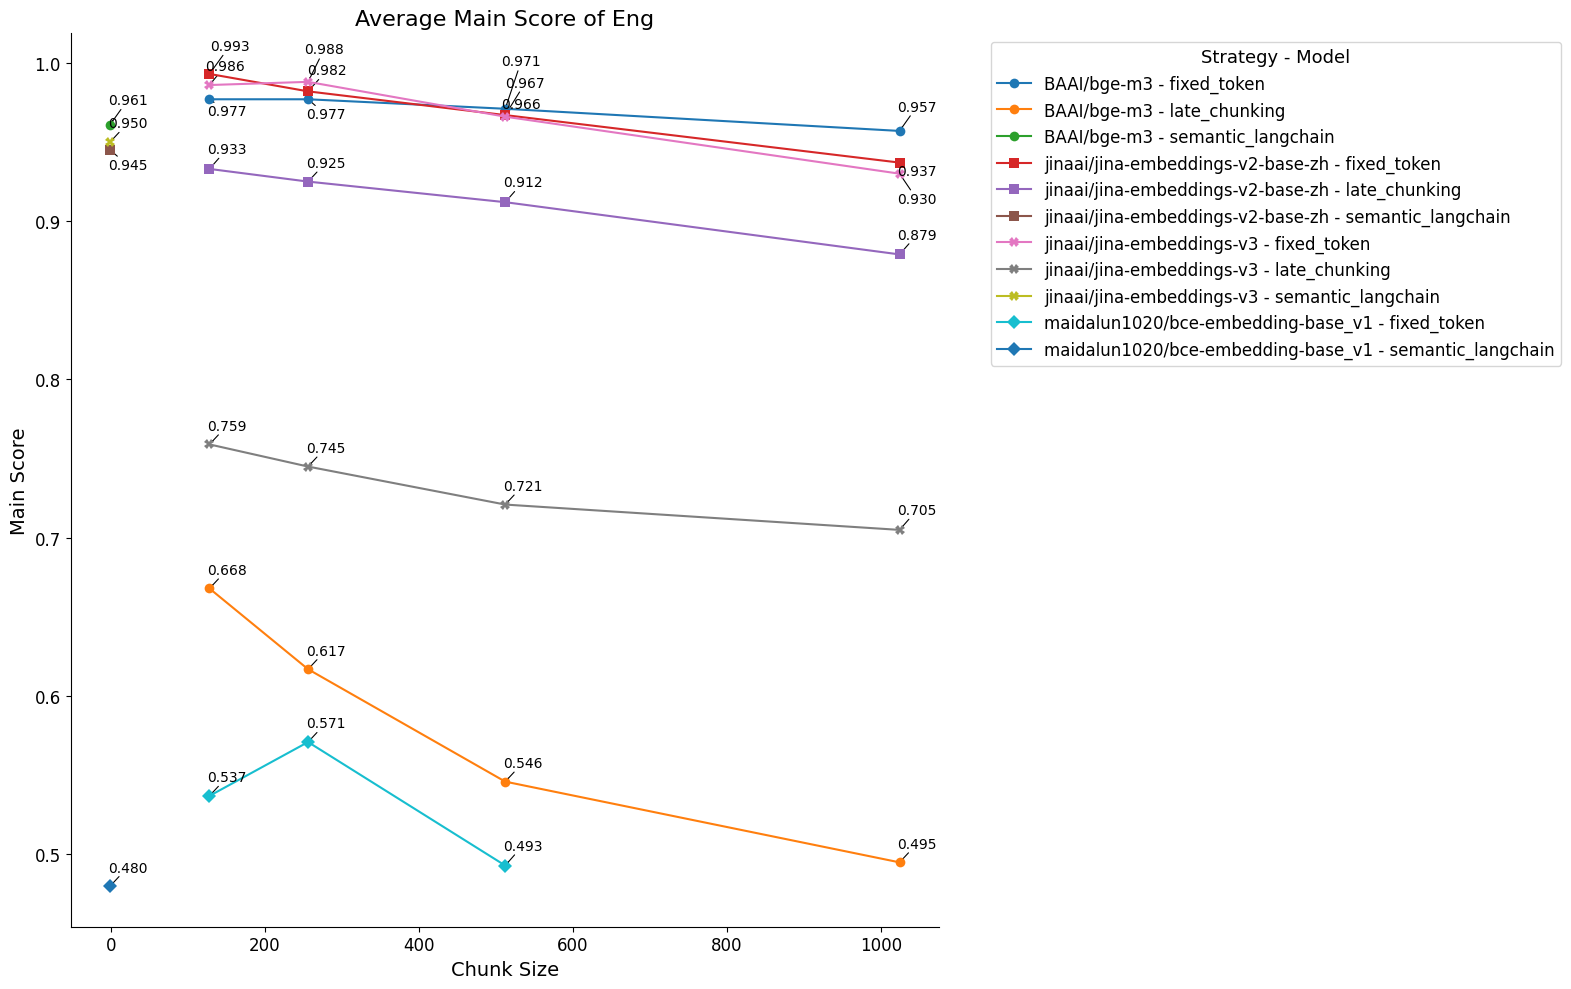

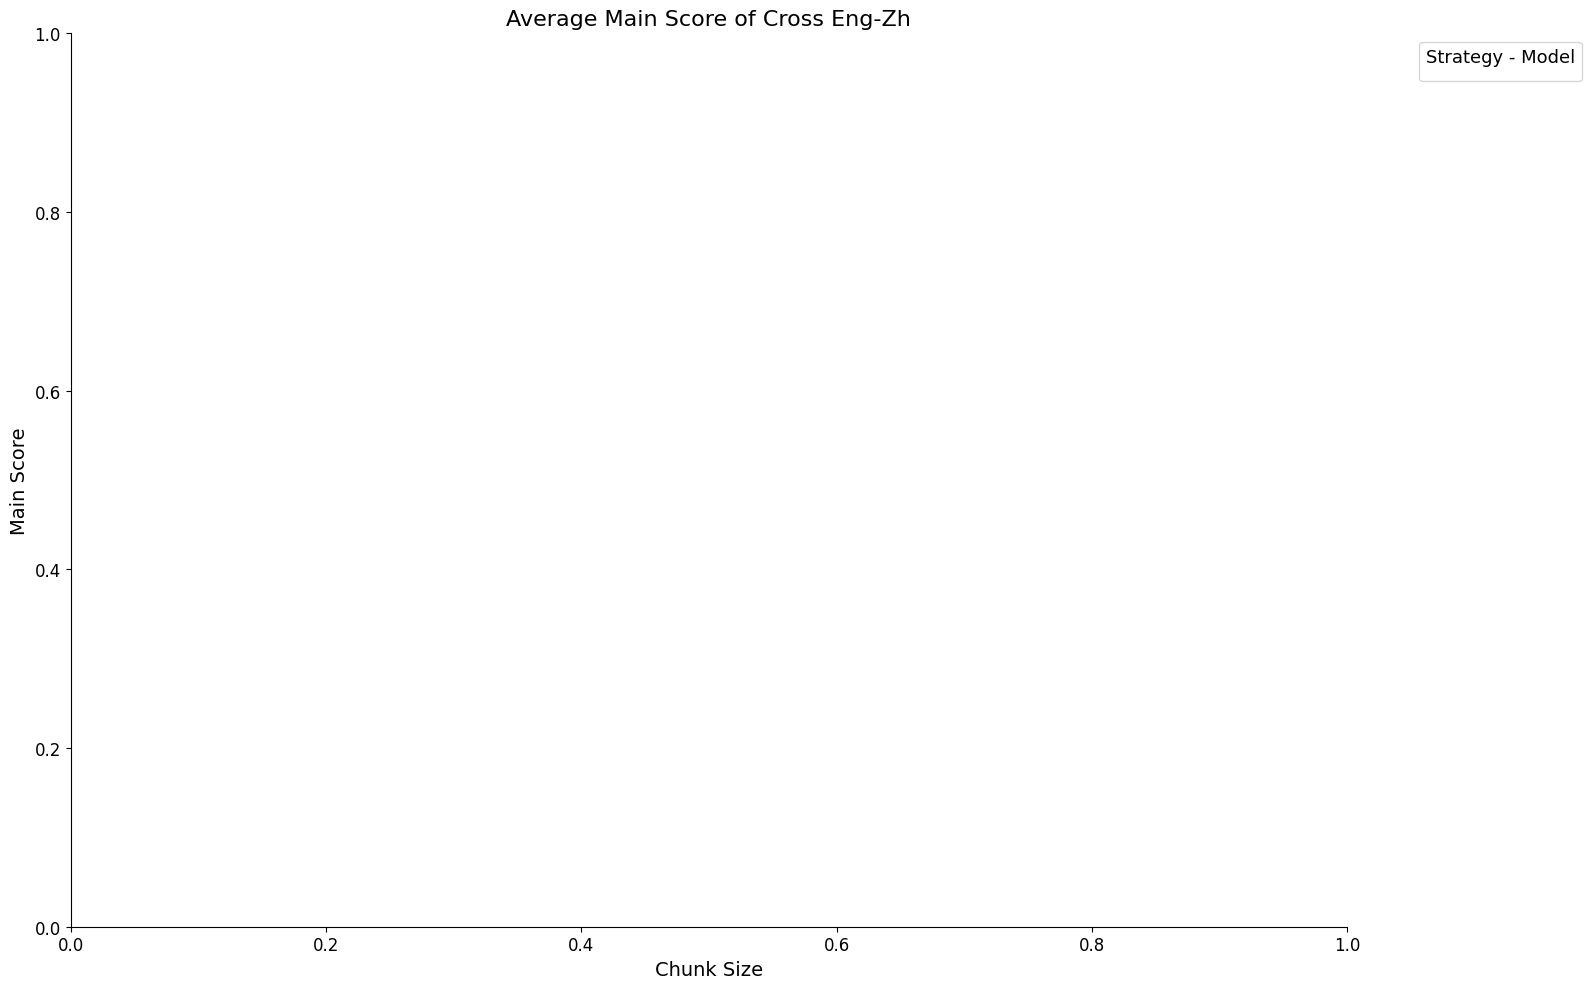

In [26]:
# 绘制按 language_category 分类的加权平均分图
categories = ['Zh', 'Eng', 'Cross Eng-Zh']
for i, category in enumerate(categories):
    cur_lang_score = avg_scores_by_language[avg_scores_by_language['language_category'] == category]
    # 创建一个新的列，将 chunking_strategy 和 model_name 组合在一起
    cur_lang_score['strategy_model'] = cur_lang_score['model_name'] + " - " + cur_lang_score['chunking_strategy']

    strategy_model = sorted(cur_lang_score['strategy_model'].unique().tolist())
    model_names = sorted(cur_lang_score['model_name'].unique().tolist())
    strategy_names = sorted(cur_lang_score['chunking_strategy'].unique().tolist())

    # 设置调色板
    palette = sns.color_palette(n_colors=len(strategy_model))

    # 定义不同模型的marker
    markers = ["o", "s", "X", "D", "^", "v", "<", ">"]  # 圆圈，方块，叉号，菱形，三角形朝上，三角形朝下，三角形朝左，三角形朝右

    # 创建一个字典来映射模型到marker
    marker_dict = {model: markers[i % len(markers)] for i, model in enumerate(model_names)}

    # 创建一个字典来映射策略模型组合到颜色
    color_dict = {strategy_model: palette[i] for i, strategy_model in enumerate(strategy_model)}

    # 绘制折线图
    text_plot = []
    points_x = []
    points_y = []
    x_raidus = 0.1
    y_radius = 0.001
    plt.figure(figsize=(16, 10))
    for strategy_model in strategy_model:
        subset = cur_lang_score[cur_lang_score['strategy_model'] == strategy_model]
        model = strategy_model.split(" - ")[0]
        mar = marker_dict[model]
        color = color_dict[strategy_model]
        plt.plot(subset['chunk_size'], subset['weighted_avg_score'], marker=mar, color=color, label=strategy_model, markeredgewidth=0, markersize=7)

        for px,py in zip(list(subset['chunk_size']), list(subset['weighted_avg_score'])):
            for dx in [x_raidus, 0, -x_raidus]:
                for dy in [y_radius, 0, -y_radius]:
                    points_x.append(px + dx)
                    points_y.append(py + dy)

        # 添加每个点的具体数值
        for i in range(len(subset)):
            x = subset['chunk_size'].iloc[i]
            y = subset['weighted_avg_score'].iloc[i]
            text_plot.append(plt.text(x, y, f'{y:.3f}', fontsize=10))
    adjust_text(text_plot, x=points_x, y=points_y,arrowprops=dict(arrowstyle='->', color='black', lw=0.8), ax=plt.gca(), max_move=50)

    # 添加图例和标签
    plt.legend(title='Strategy - Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='13')
    plt.xlabel("Chunk Size", fontsize=14)
    plt.ylabel("Main Score", fontsize=14)
    plt.title(f'Average Main Score of {category}', fontsize=16)

    # 设置刻度字体大小
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # 美观起见隐藏顶部与右侧边框线
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    # 显示图形
    plt.tight_layout()
    plt.show()